In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
nltk.download('stopwords')
STOPWORDS = set(stopwords.words('english'))

from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV,StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,ConfusionMatrixDisplay
from wordcloud import WordCloud
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import pickle
import re
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\AMAN\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [23]:
# Loading the dataset
data = pd.read_csv(r"C:\Users\AMAN\Downloads\DATA Scientist\GitHub\NLP Learning\Projects\Sentiment Analysis\amazon_alexa.tsv",sep='\t')

In [24]:
data.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [25]:
data.isnull().sum()

rating              0
date                0
variation           0
verified_reviews    1
feedback            0
dtype: int64

In [26]:
data = data.dropna()

In [27]:
data.shape

(3149, 5)

In [28]:
data['length'] = data['verified_reviews'].apply(len)

In [29]:
data.head()

,rating,date,variation,verified_reviews,feedback,length
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,9
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1,195
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1,172
4,5,31-Jul-18,Charcoal Fabric,Music,1,5


In [30]:
data.dtypes

rating               int64
date                object
variation           object
verified_reviews    object
feedback             int64
length               int64
dtype: object

# Analyzing Rating Column

In [31]:
print(f"Rating Value Count:\n{data['rating'].value_counts()}")

Rating Value Count:
rating
5    2286
4     455
1     161
3     152
2      95
Name: count, dtype: int64


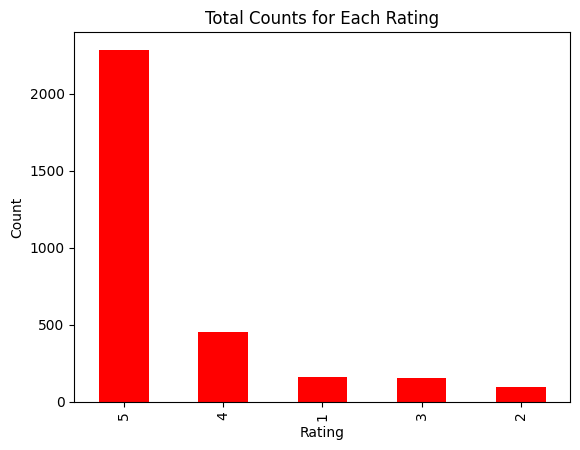

In [32]:
# Bar Plot to visualize the total counts for each rating

data['rating'].value_counts().plot(color='red',kind='bar')
plt.title('Total Counts for Each Rating')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

In [33]:
# Finding the Percentage of each rating
print(f"Rating value count percentage:\n{round(data['rating'].value_counts(normalize=True)*100,2)}")

Rating value count percentage:
rating
5    72.59
4    14.45
1     5.11
3     4.83
2     3.02
Name: proportion, dtype: float64


# Analyzing feedback Column

In [34]:
print(f"feedback value count :\n{data['feedback'].value_counts()}")

feedback value count :
feedback
1    2893
0     256
Name: count, dtype: int64


In [35]:
review_0 = data[data['feedback'] == 0].iloc[1]['verified_reviews']
review_1 = data[data['feedback'] == 1].iloc[1]['verified_reviews']
print(f"Review with feedback 0:\n{review_0}")
print(f"Review with feedback 1:\n{review_1}")

Review with feedback 0:
Sound is terrible if u want good music too get a bose
Review with feedback 1:
Loved it!


In [36]:
print("Feedback 1 has POSITIVE REVIEWS")
print("Feedback 2 has NEGATIVE REVIEWS")

Feedback 1 has POSITIVE REVIEWS
Feedback 2 has NEGATIVE REVIEWS


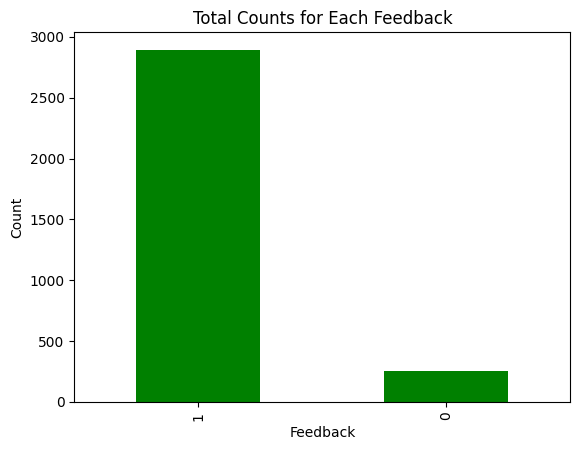

In [37]:
data['feedback'].value_counts().plot(kind='bar',color='green')
plt.xlabel('Feedback')
plt.ylabel('Count')
plt.title('Total Counts for Each Feedback')
plt.show()

In [38]:
# Percentage of Feedback value_count Column
print(f"Feedback value count percentage:\n{round(data['feedback'].value_counts(normalize=True)*100,2)}")

Feedback value count percentage:
feedback
1    91.87
0     8.13
Name: proportion, dtype: float64


In [39]:
# Negative Reviews and Count of their Ratings
data[data['feedback'] == 0]['rating'].value_counts()

rating
1    161
2     95
Name: count, dtype: int64

In [40]:
# Postive review and count of their Ratings
data[data['feedback'] == 1]['rating'].value_counts()

rating
5    2286
4     455
3     152
Name: count, dtype: int64

# Analyze Various Column

In [41]:
print(f"Date value count:\n{data['variation'].value_counts()}")

Date value count:
variation
Black  Dot                      516
Charcoal Fabric                 430
Configuration: Fire TV Stick    350
Black  Plus                     270
Black  Show                     265
Black                           261
Black  Spot                     241
White  Dot                      184
Heather Gray Fabric             157
White  Spot                     109
Sandstone Fabric                 90
White                            90
White  Show                      85
White  Plus                      78
Oak Finish                       14
Walnut Finish                     9
Name: count, dtype: int64


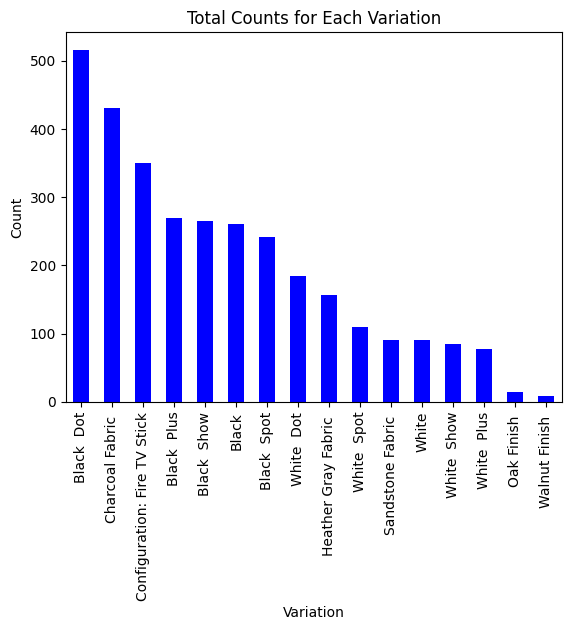

In [42]:
# Plotting Bar Graph on Variation column
data['variation'].value_counts().plot(kind='bar',color='blue')
plt.xlabel('Variation')
plt.ylabel('Count')
plt.title('Total Counts for Each Variation')
plt.show()

In [43]:
# Percentage of Value Counts of Variation Column
print(f"Variation value count percentage:\n{round(data['variation'].value_counts(normalize=True)*100,2)}")

Variation value count percentage:
variation
Black  Dot                      16.39
Charcoal Fabric                 13.66
Configuration: Fire TV Stick    11.11
Black  Plus                      8.57
Black  Show                      8.42
Black                            8.29
Black  Spot                      7.65
White  Dot                       5.84
Heather Gray Fabric              4.99
White  Spot                      3.46
Sandstone Fabric                 2.86
White                            2.86
White  Show                      2.70
White  Plus                      2.48
Oak Finish                       0.44
Walnut Finish                    0.29
Name: proportion, dtype: float64


In [44]:
# Mean rating according to variation
mean_ratings = round(data.groupby('variation')['rating'].mean(),3)
print(mean_ratings)

variation
Black                           4.234
Black  Dot                      4.453
Black  Plus                     4.370
Black  Show                     4.491
Black  Spot                     4.311
Charcoal Fabric                 4.730
Configuration: Fire TV Stick    4.591
Heather Gray Fabric             4.694
Oak Finish                      4.857
Sandstone Fabric                4.356
Walnut Finish                   4.889
White                           4.167
White  Dot                      4.424
White  Plus                     4.359
White  Show                     4.282
White  Spot                     4.312
Name: rating, dtype: float64


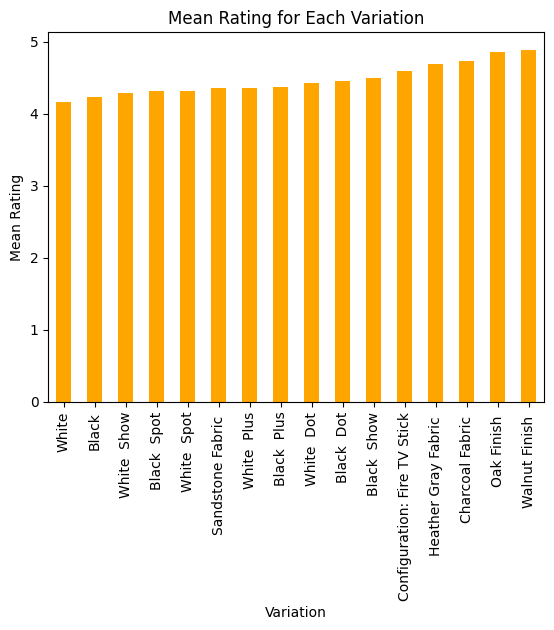

In [45]:
# Plotting Bar Graph for means of the ratings of the variation

mean_ratings.sort_values(ascending=True).plot.bar(color='orange')
plt.xlabel('Variation')
plt.ylabel('Mean Rating')
plt.title('Mean Rating for Each Variation')
plt.show()

# Analyzing verified_reviews Column

In [46]:
data['length'].describe()

count    3149.000000
mean      132.090187
std       182.114569
min         1.000000
25%        30.000000
50%        74.000000
75%       165.000000
max      2851.000000
Name: length, dtype: float64

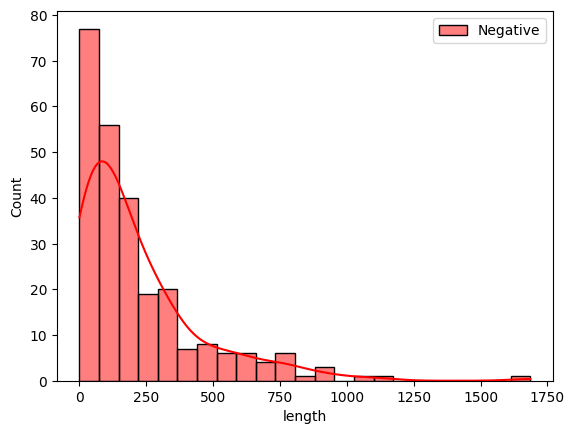

In [47]:
# Histplot of Negative Reviews
sns.histplot(data[data['feedback']==0]['length'],color='red',label='Negative',kde=True)
plt.legend()

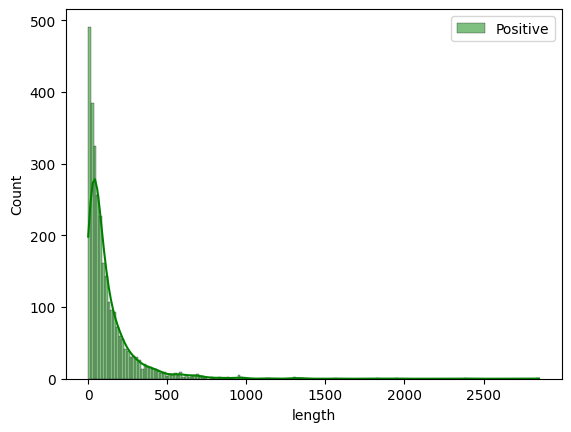

In [48]:
# Histplot of Positive Reviews
sns.histplot(data[data['feedback']==1]['length'],color='green',label='Positive',kde=True)
plt.legend()

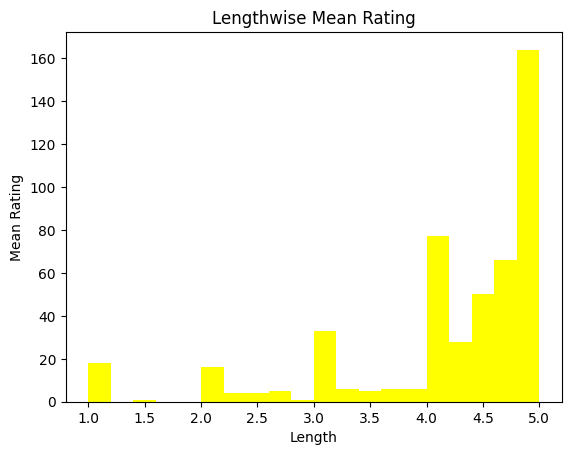

In [49]:
# Lengthwise Mean Rating
data.groupby('length')['rating'].mean().plot.hist(color='yellow',bins=20)
plt.xlabel('Length')
plt.ylabel('Mean Rating')
plt.title('Lengthwise Mean Rating')
plt.show()

In [50]:
cv = CountVectorizer(stop_words='english')
words = cv.fit_transform(data['verified_reviews'])

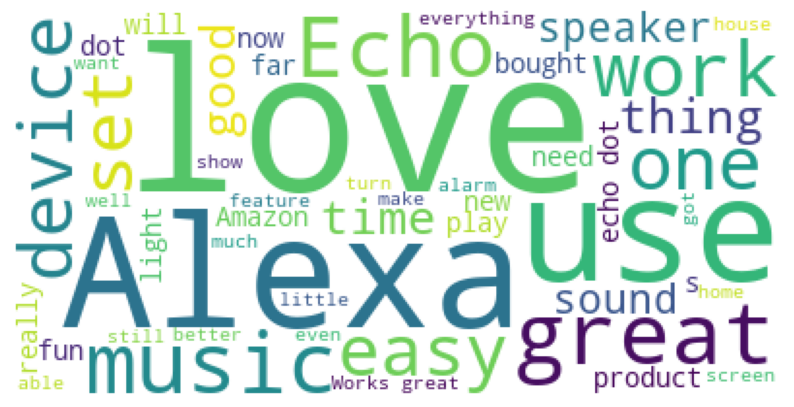

In [51]:
# Combining all the reviews
reviews = " ".join([review for review in data['verified_reviews']])

# Initializing wordcloud object
wc = WordCloud(background_color='white',max_words=50)

# Generating and ploting Word Cloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(reviews))
plt.axis('off')
plt.show()

In [52]:
# Combining all reviews for each feedback category and splitting them into individual words
neg_reviews = " ".join([review for review in data[data['feedback']==0]['verified_reviews']])
neg_reviews = neg_reviews.lower().split()

pos_reviews = " ".join([review for review in data[data['feedback']==1]['verified_reviews']])
pos_reviews = pos_reviews.lower().split()

# Finding words from reviews which are present in feedback Category
unique_neg = [x for x in neg_reviews if x not in pos_reviews]
unique_neg = " ".join(unique_neg)

unique_pos = [x for x in pos_reviews if x not in neg_reviews]
unique_pos = " ".join(unique_pos)


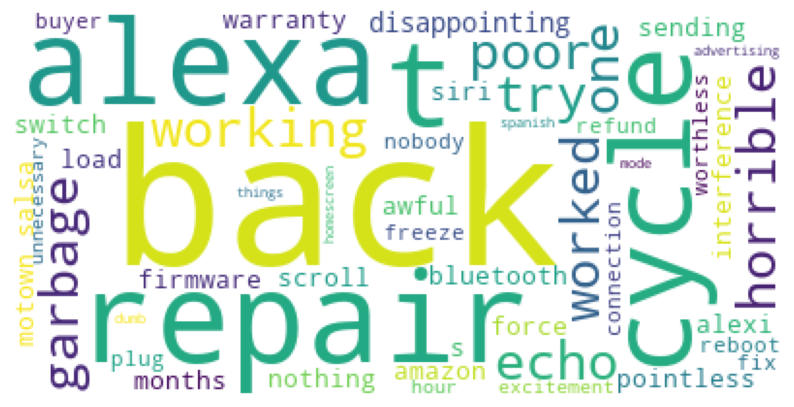

In [53]:
# Generating wordcloud for Negative Reviews
wc = WordCloud(background_color='white',max_words=50)
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(unique_neg))
plt.axis('off')
plt.show()

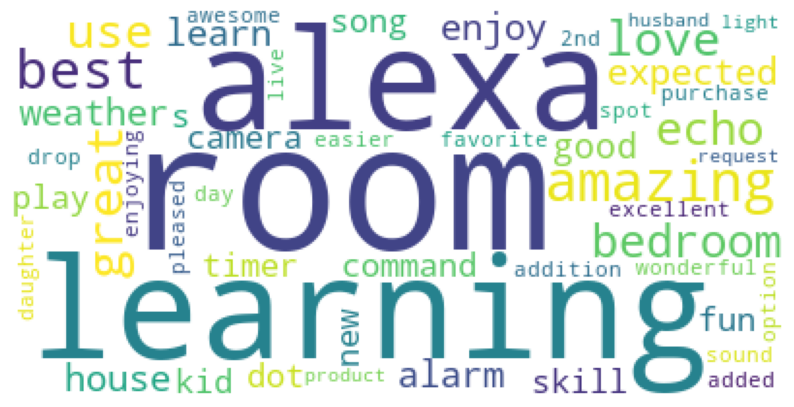

In [54]:
# Generating wordcloud for Positive Reviews
wc = WordCloud(background_color='white',max_words=50)
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(unique_pos))
plt.axis('off')
plt.show()

# MODEL BUILDING

In [55]:
corpus = []
stemmer = PorterStemmer()
for i in range(0,data.shape[0]):
  review = re.sub('[^a-zA-Z]', ' ',data.iloc[i]['verified_reviews'])
  review = review.lower().split()
  review = [stemmer.stem(word) for word in review if not word in STOPWORDS]
  review = ' '.join(review)
  corpus.append(review)


In [56]:
# Creating bag of words using Count Vectorizer
cv = CountVectorizer(max_features=2500)

# Splitting the features in X and Y
x = cv.fit_transform(corpus).toarray()
y = data['feedback'].values

In [57]:
# Checking the shape of X AND Y
print(f"Shape of X: {x.shape}")
print(f"Shape of Y: {y.shape}")

Shape of X: (3149, 2500)
Shape of Y: (3149,)


In [58]:
# Saving the CountVectorizer
pickle.dump(cv,open('CountVectorizer.pkl','wb'))

In [59]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=20)

print(f"x_train shape: {x_train.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")


x_train shape: (2204, 2500)
x_test shape: (945, 2500)
y_train shape: (2204,)
y_test shape: (945,)


In [60]:
# Scaling
scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [61]:
# Saving the scaler Model
pickle.dump(scaler,open('scaler.pkl','wb'))

In [62]:
rf_model = RandomForestClassifier()
rf_model.fit(x_train_scaled,y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [63]:
# Showing the accuracy of model
print(f"Training Accuracy: {round(rf_model.score(x_train_scaled,y_train)*100,2)}%")
print(f"Testing Accuracy: {round(rf_model.score(x_test_scaled,y_test)*100,2)}%")


Training Accuracy: 99.32%
Testing Accuracy: 93.97%


In [64]:
# Prediction on the test data
y_pred = rf_model.predict(x_test_scaled)

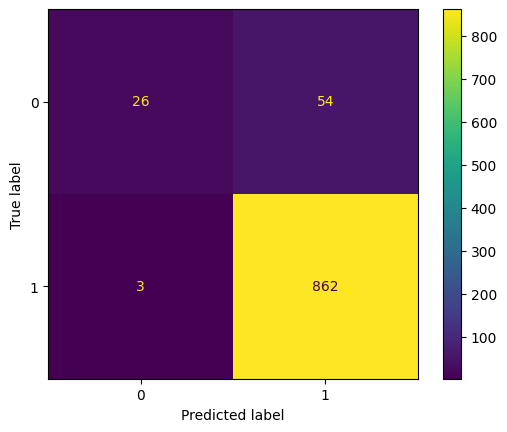

In [65]:
# Confusion Matrix
cm = confusion_matrix(y_test,y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=rf_model.classes_)
cm_display.plot()
plt.show()

In [66]:
# HYPERPARAMETERTUNING
params = {
    'bootstrap':[True],
    'max_depth':[10,20,30,40,50,60,70,80,90,100,None],
    'max_features':['auto','sqrt'],
    'n_estimators':[100,300]
}

gr = GridSearchCV(estimator=rf_model,param_grid=params,cv=3,n_jobs=-1,verbose=2)
gr.fit(x_train_scaled,y_train)

Fitting 3 folds for each of 44 candidates, totalling 132 fits


,estimator,RandomForestClassifier()
,param_grid,"{'bootstrap': [True], 'max_depth': [10, 20, ...], 'max_features': ['auto', 'sqrt'], 'n_estimators': [100, 300]}"
,scoring,None
,n_jobs,-1
,refit,True
,cv,3
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,300


In [67]:
# Displaying the best Parameters
gr.best_params_

{'bootstrap': True,
 'max_depth': 100,
 'max_features': 'sqrt',
 'n_estimators': 300}

In [68]:
best_params = {
    'bootstrap': [True],
    'max_depth': [90],
    'max_features': ['sqrt'],
    'n_estimators': [100]}

In [69]:
# Building the model on Best Parameters
gr = GridSearchCV(estimator=rf_model,param_grid=best_params,cv=3,n_jobs=-1,verbose=2)
gr.fit(x_train_scaled,y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


,estimator,RandomForestClassifier()
,param_grid,"{'bootstrap': [True], 'max_depth': [90], 'max_features': ['sqrt'], 'n_estimators': [100]}"
,scoring,None
,n_jobs,-1
,refit,True
,cv,3
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,100


In [70]:
from sklearn.metrics import accuracy_score
y_pred_gr = gr.predict(x_test_scaled)
print(accuracy_score(y_test,y_pred_gr)*100)

92.8042328042328


In [71]:
# XGBOOST
xgb = XGBClassifier()
xgb.fit(x_train_scaled,y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [72]:
# Checking the accuracy of XGBOOST Model
print(f"Training Accuracy: {round(xgb.score(x_train_scaled,y_train)*100,2)}%")
print(f"Testing Accuracy: {round(xgb.score(x_test_scaled,y_test)*100,2)}%")

Training Accuracy: 97.46%
Testing Accuracy: 93.44%


In [73]:
# Saving the best Model
pickle.dump(xgb,open('xgb.pkl','wb'))